<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Social Networks</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import tqdm as tq
from tqdm import tqdm
import os

import networkx as nx
import random
import wget

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 607256d2c68948a39f7161a27e9658f882436a28

pandas    : 1.1.3
tqdm      : 4.62.0
wget      : 3.2
matplotlib: 3.3.2
json      : 2.0.9
numpy     : 1.19.2
watermark : 2.1.0
networkx  : 2.5



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Graph Models

### Erdős-Rényi 

Graph models are simple algorithms to generate graph topologies. We start with Erdős-Rényi model where each pair of nodes is added with a fixed probability

In [4]:
def erdos_renyi_graph(N, p):
    nodes = list(range(N))
    edges = []
    
    # Try every pair of edges
    for i in range(N):
        for j in range(i+1, N):
            
            # add edge with probability p
            if np.random.random() < p:
                edges.append((i, j))
    
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    return G

Let's generate a relatively small ER graph

In [5]:
ER = erdos_renyi_graph(10_000, 0.01)

With these parameters, we expect the average degree to be $\langle k\rangle=Np=100$ and the distribution to be approximately Gaussian. We start by generating the degre distribution

In [6]:
Pk = pd.DataFrame(Counter(dict(ER.degree()).values()).items(), columns=['k', 'Pk']).sort_values('k')
Pk.Pk/=10_000

And compute the theoretical distribution

In [7]:
Pk_theory = Pk.copy()
Pk_theory.Pk = Pk_theory.k.map(lambda k: np.exp(-100)/np.math.factorial(k)*100**k)

So that we can more easily compare them:

Text(0, 0.5, 'P(k)')

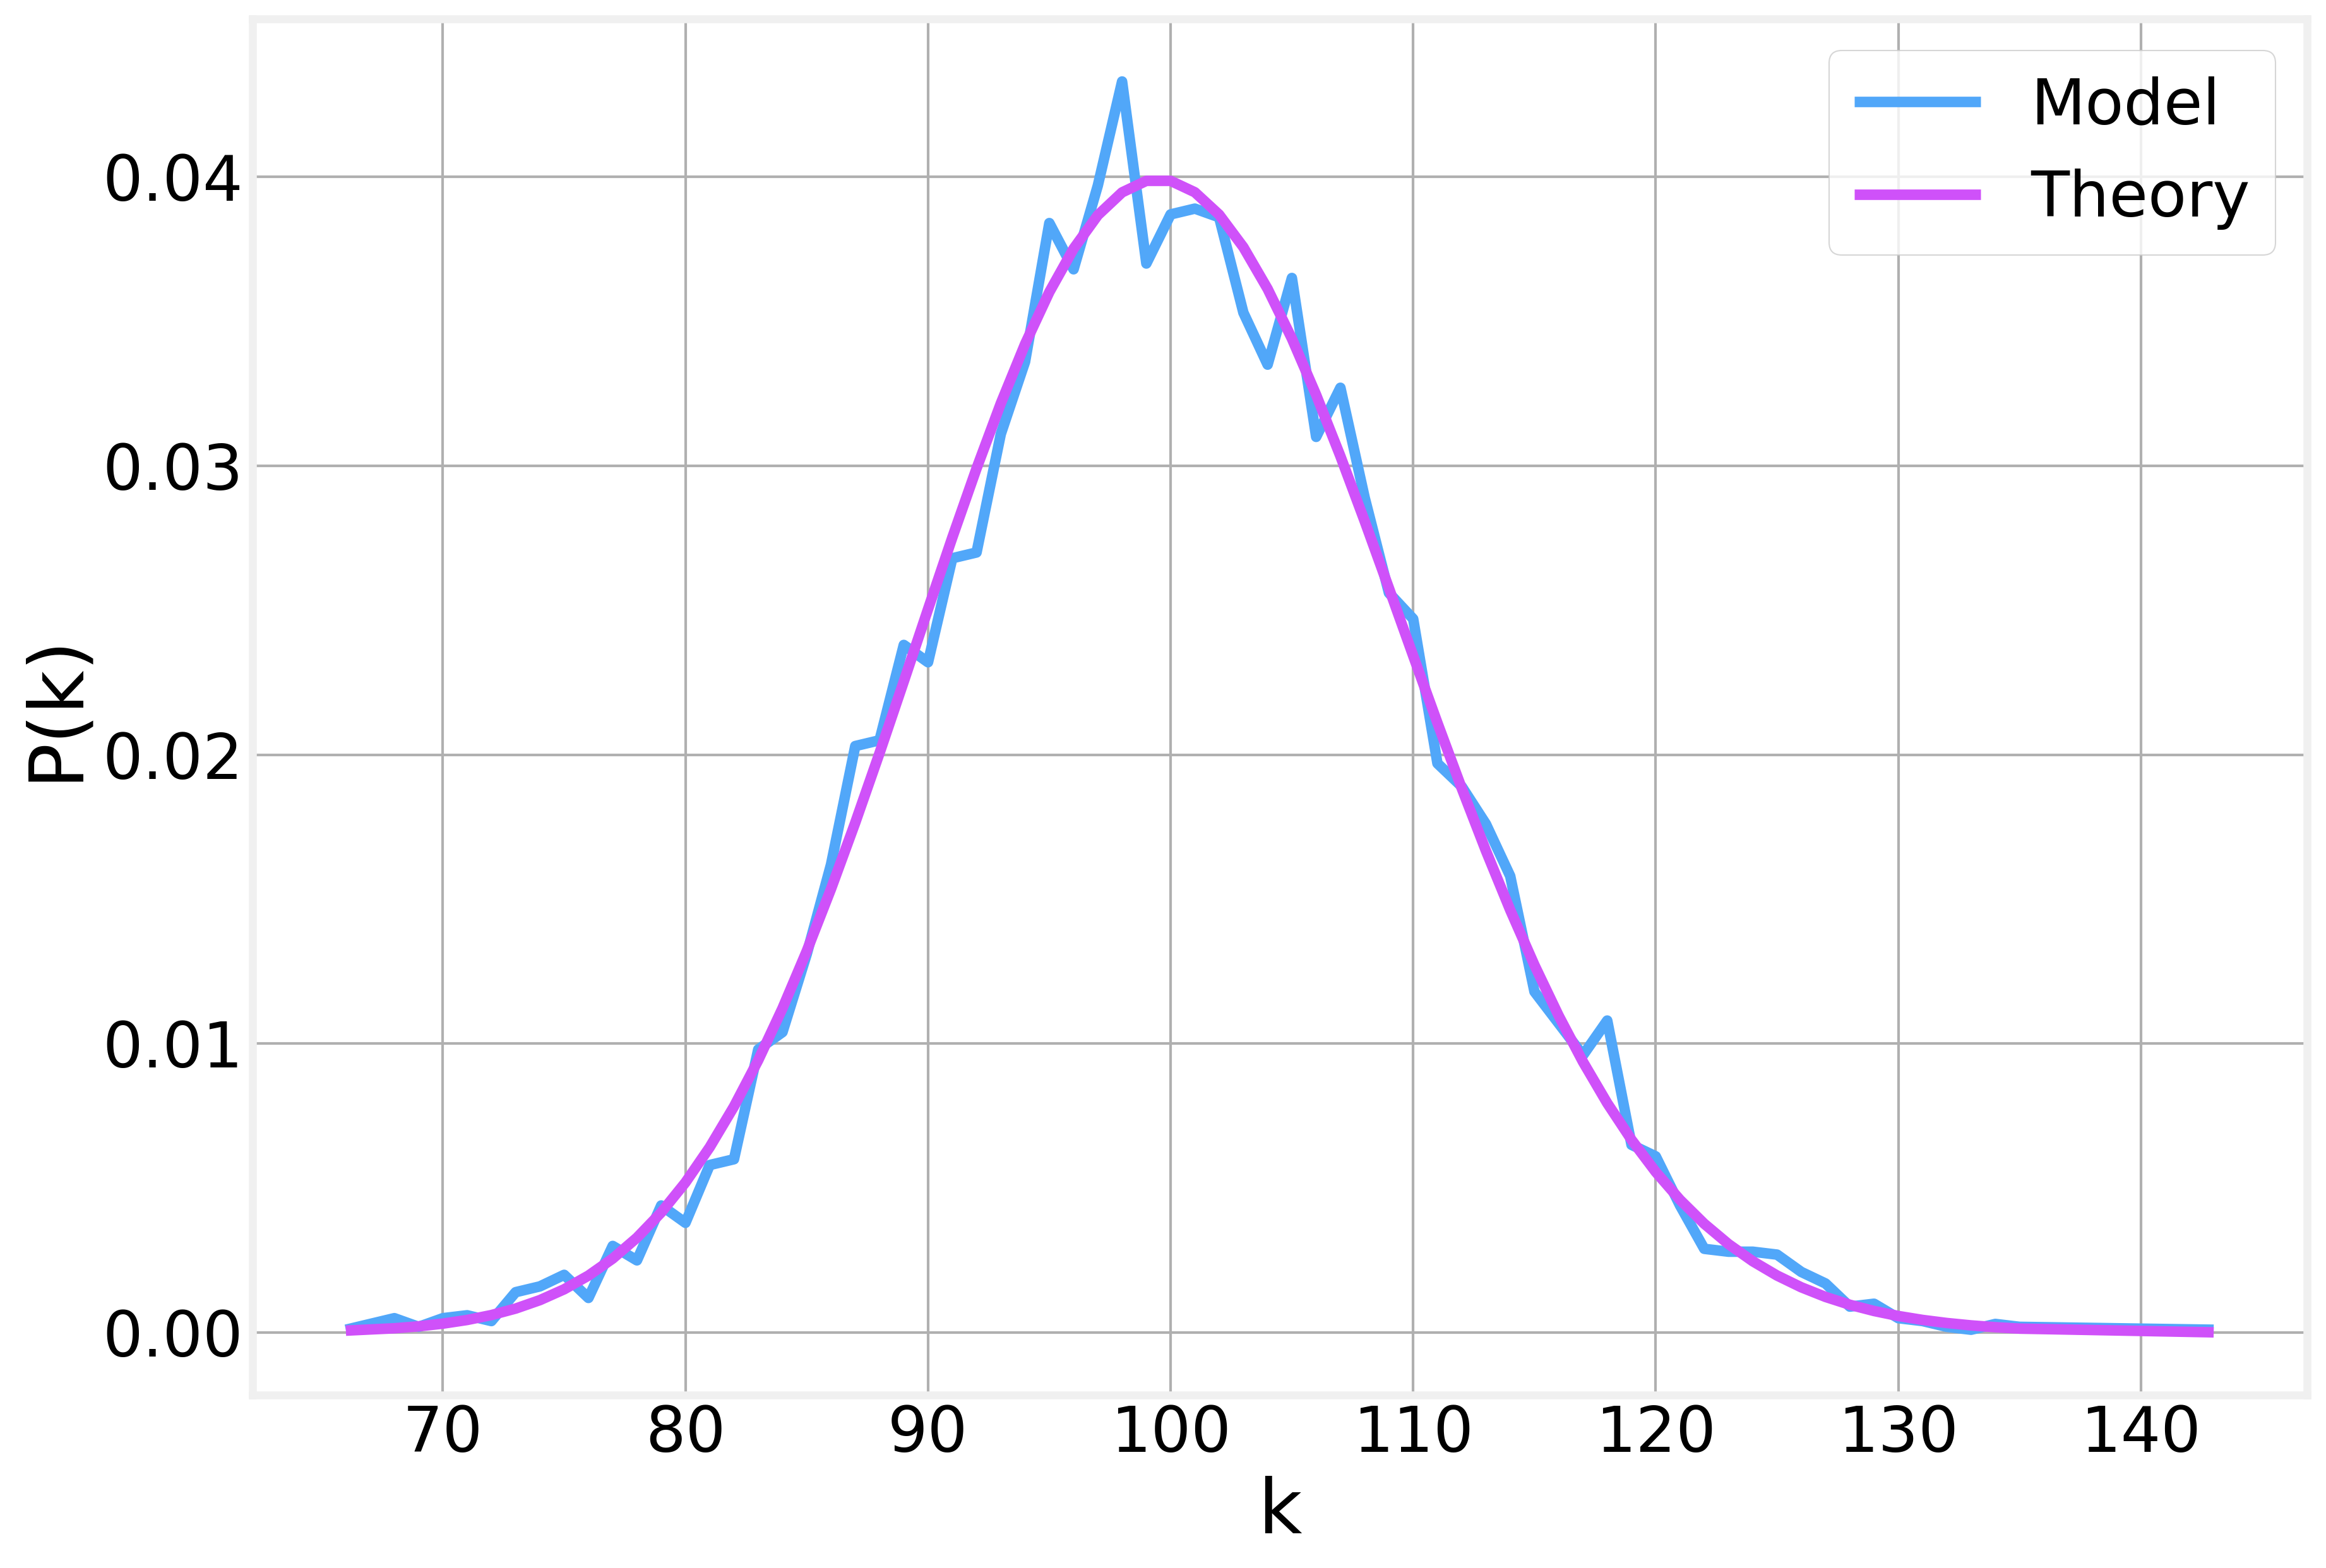

In [8]:
ax = Pk.plot(x='k', y='Pk')
Pk_theory.plot(x='k', y='Pk', ax=ax)
ax.legend(['Model', 'Theory'])
ax.set_xlabel('k')
ax.set_ylabel('P(k)')

Not a bad math at all!

Finally, the average degree is, simply:

$$\langle k \rangle=\sum_k k P(k)$$

In [9]:
kavg = np.dot(Pk.k, Pk.Pk)
print(kavg)

100.11900000000001


as expected

# Clustering Coefficient

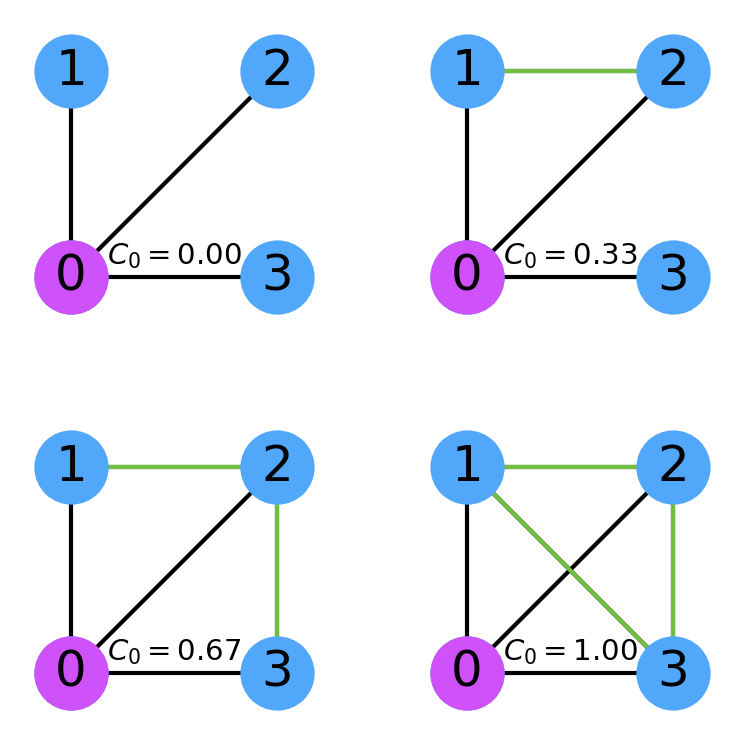

In [10]:
fig, ax_lst = plt.subplots(2,2, figsize=(3, 3))
ax_lst = np.array(ax_lst).flatten()

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, i) for i in range(1, 4)])

edge_seq = [[], [1, 2], [2, 3], [1, 3]]

pos = {
    0: (0, 0),
    1: (0, 1),
    2: (1, 1),
    3: (1, 0)}

for i in range(4):
    if i > 0:
        G.add_edge(*edge_seq[i])
    
    nx.draw(G, pos, ax=ax_lst[i], node_color=colors[0])
    nx.draw_networkx_nodes(G, pos, [0], ax=ax_lst[i], node_color=colors[1])
    nx.draw_networkx_labels(G, pos, ax=ax_lst[i])
    
    C = nx.clustering(G)[0]
    ax_lst[i].text(0.5, 0.1, r"$C_0=%1.2f$" % C, fontsize=7, ha='center', va='center')

    
    if i>0:
        nx.draw_networkx_edges(G, pos, list(edge_seq[1:i+1]), ax=ax_lst[i], edge_color=colors[2])
    
    ax_lst[i].axis('off')
    ax_lst[i].set_xlim(-0.2, 1.2)
    ax_lst[i].set_ylim(-0.2, 1.2)

fig.tight_layout()

Let us define a simple function to extract the adjacency matrix of a graph

In [11]:
def get_adjacency_matrix(G):
    N = G.number_of_nodes()
    
    A = np.zeros((N, N))
    
    for node_i, node_j in G.edges():
        A[node_i, node_j] = 1
        A[node_j, node_i] = 1
        
    return A

In [12]:
A = get_adjacency_matrix(ER)

We compute the number of triangles for each node using matrix multiplication. In practice, there are significanlty more efficient ways of doing for large networks

In [13]:
triangles = np.diag(np.linalg.matrix_power(A, 3))

And compute the degree coefficient of each node

In [14]:
deg = ER.degree()

In [15]:
C = [count/(deg(i)*(deg(i)-1)) for i, count in enumerate(triangles)]

The average clustering coefficient is then:

In [16]:
np.mean(C)

0.010014089174576673

Which is pretty close to the value of p, as expected

### Regular Ring

We now proceed to defining a regular ring graph where each node is connected with K/2 neighbors on the left and K/2 neighbours on the right. This will be a stepping stone towards the full fledged Watts-Strogats model

In [17]:
def ring_graph(N, K):
    nodes = np.arange(N)
    edges = []
    
    K = K//2
    
    for i in range(N):
        for j in range(i+1, i+K+1):
            edges.append((i, j%N))
        
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

To generate a small regular ring we simply do

In [18]:
N = 100
K = 4
RG = ring_graph(N, K)

Naturally the degree distribution is pretty simple

In [19]:
Pk = pd.DataFrame(Counter(dict(RG.degree()).values()).items(), columns=['k', 'Pk']).sort_values('k')
Pk.Pk/=N

With all nodes having degree 4

In [20]:
Pk

,k,Pk
0,4,1.0


### Watts-Strogatz model

The first step towards defining a WS model is to implementing the rewiring procedure. This takes an existing graph and randomly rewires it's edges with probability $p$

In [21]:
def rewire(G, p):
    node_labels = list(G.nodes)
    nodes = dict(zip(node_labels, range(len(node_labels))))
    
    edges = G.edges()
        
    for node_i, node_j in edges:
        # Make sure we just rewire one end of the edge
        if nodes[node_j] > nodes[node_i]: 
            prob = np.random.random()

            if prob < p:
                new_node_j = node_labels[np.random.randint(len(node_labels))]
                G.add_edge(node_i, new_node_j)
                G.remove_edge(node_i, node_j)

So if we apply it to the previous graph, we significantly impact the degree distribution

In [22]:
RG = ring_graph(10000, 4)
rewire(RG, 0.3)

In [23]:
Pk = pd.DataFrame(Counter(dict(RG.degree()).values()).items(), columns=['k', 'Pk']).sort_values('k')
Pk.Pk/=10000

Which is now significantly broader while still peaked at 4

Text(0, 0.5, 'P(k)')

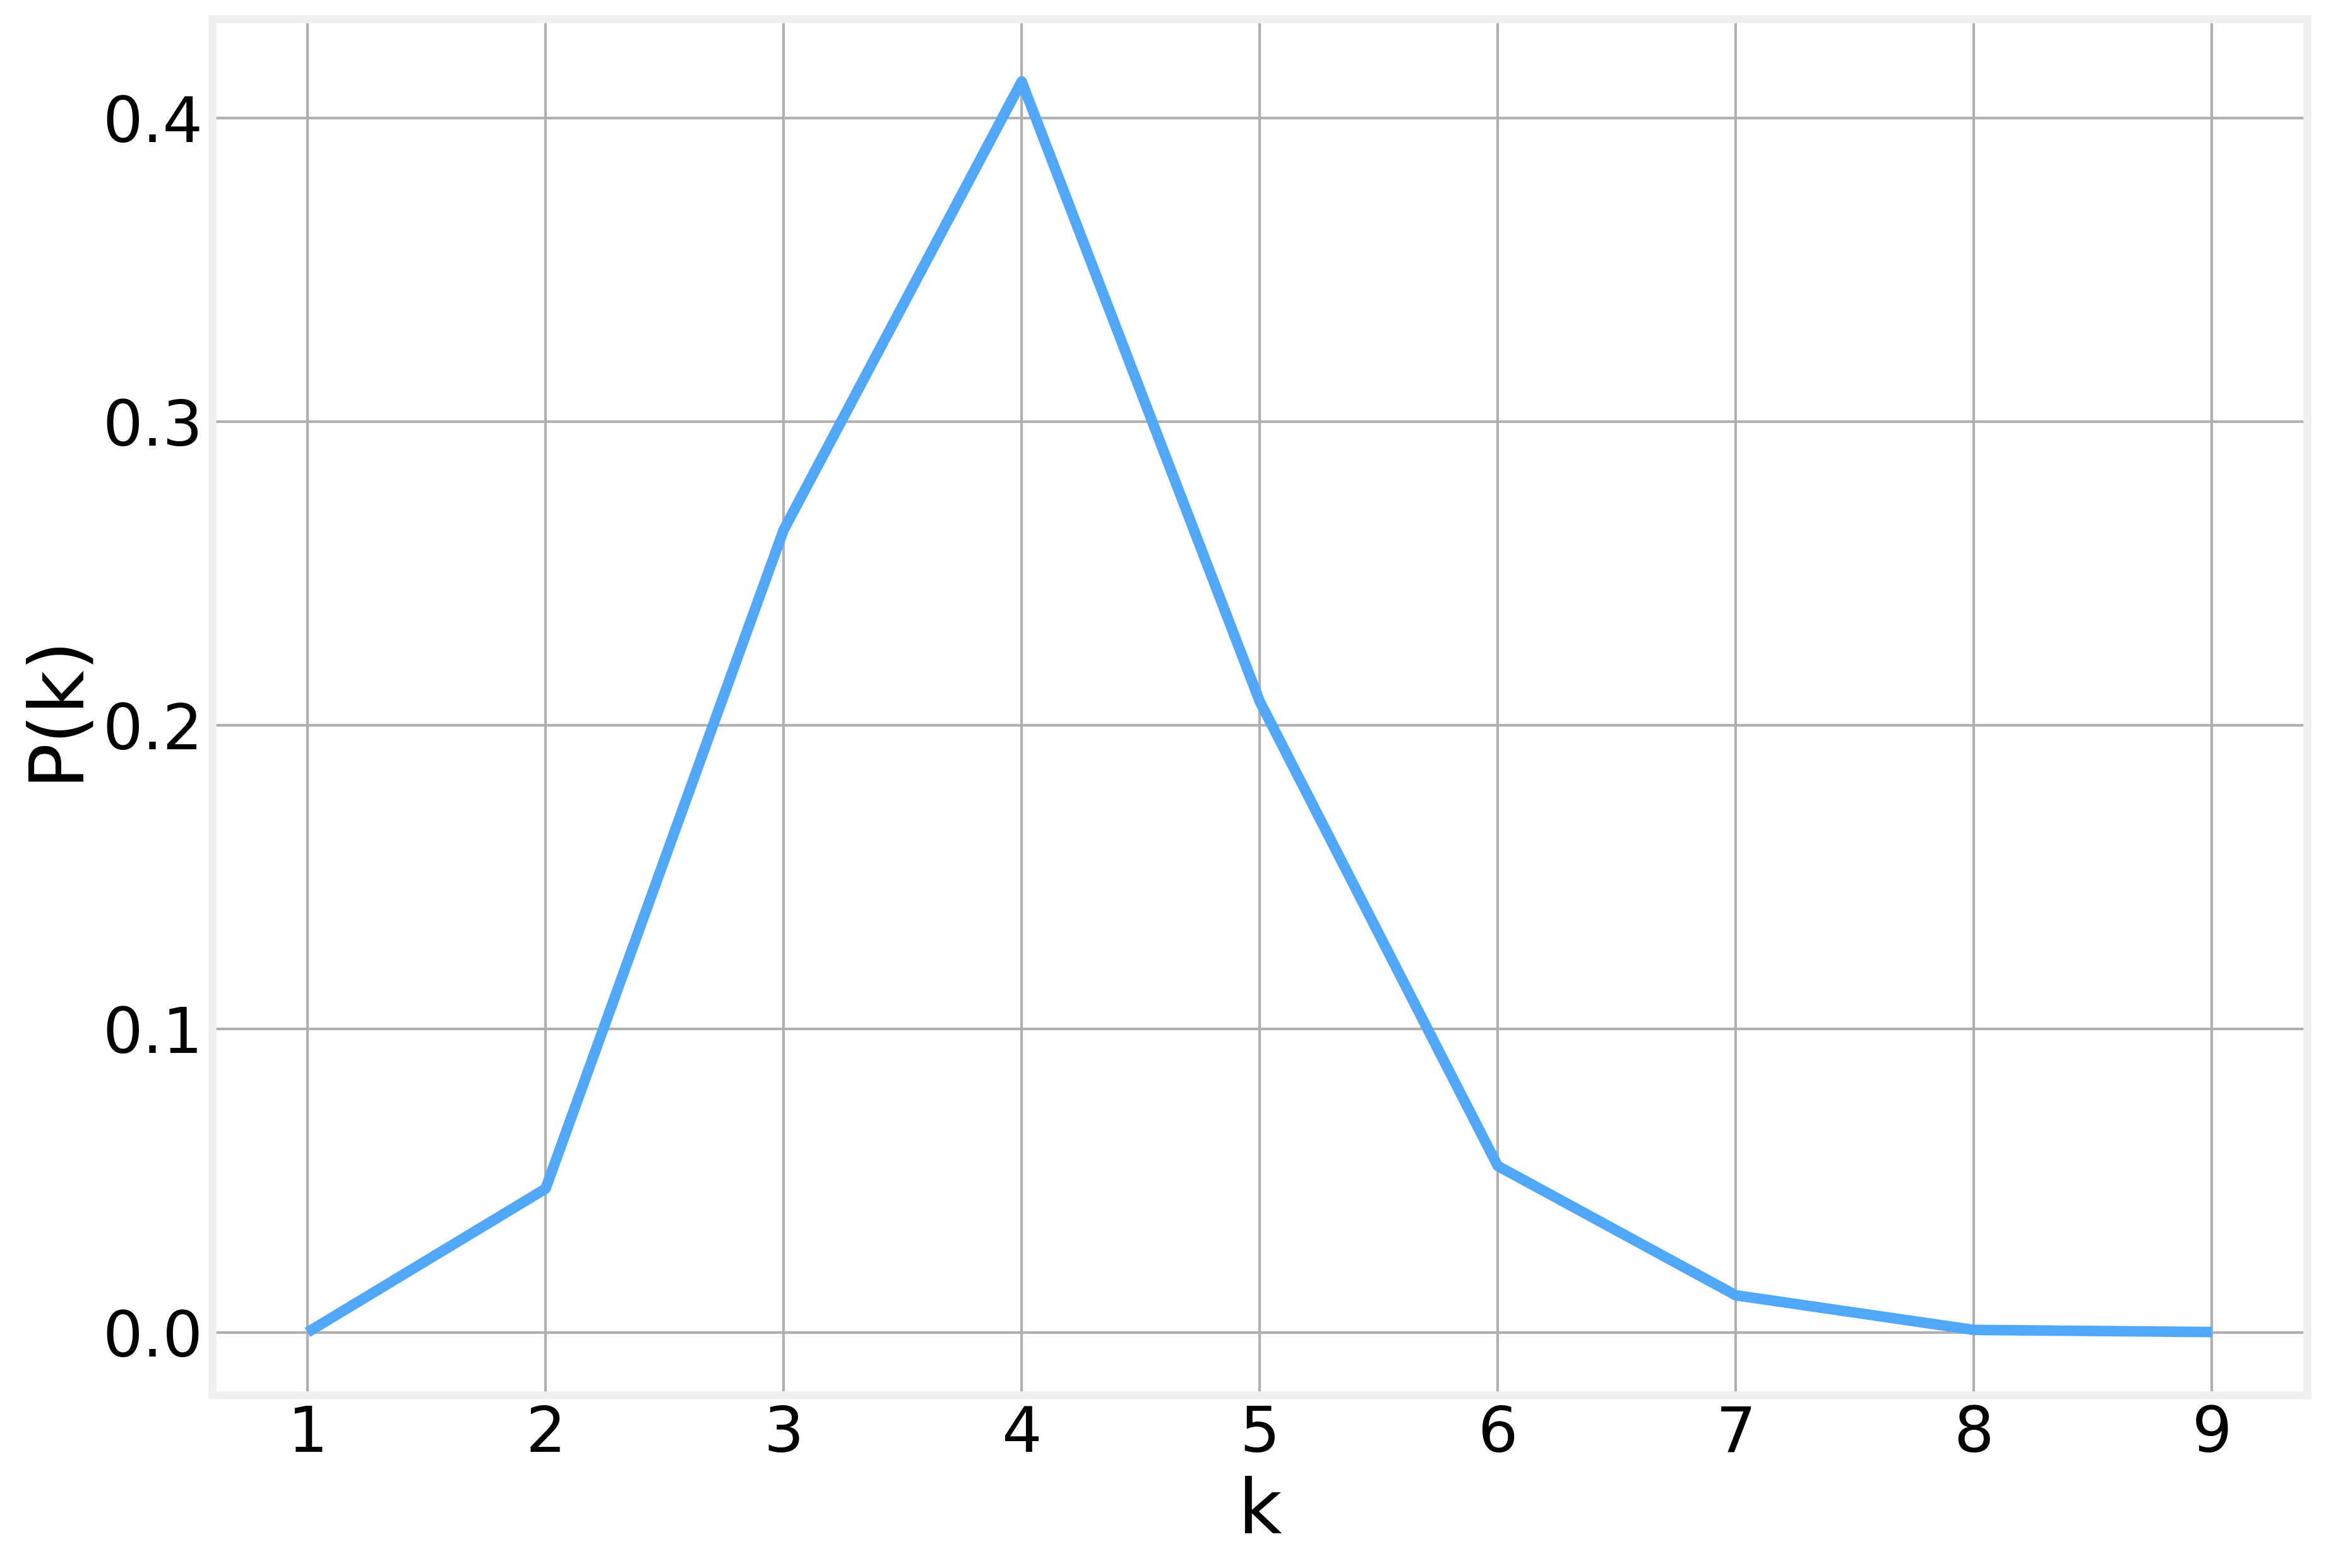

In [24]:
ax = Pk.plot(x='k', y='Pk', legend=None)
ax.set_xlabel('k')
ax.set_ylabel('P(k)')

The Watts-Strogatz model is then, simply

In [25]:
def watts_strogatz_graph(N, K, p):
    G = ring_graph(N, K)
    rewire(G, p)
    
    return G

# Small World Effect

We measure the clustering and average shortest path for various values of p

In [26]:
p = 1
values = []

for i in tqdm(range(1, 16), total=15):
    G = watts_strogatz_graph(1_000, 4, p)
    c = nx.algorithms.cluster.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    values.append([c, l, p])
    p /= 2.

100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


And plot them

In [27]:
WS_stats = pd.DataFrame(values, columns=['clustering', 'diameter', 'p'])
WS_stats = WS_stats.div(WS_stats.max())

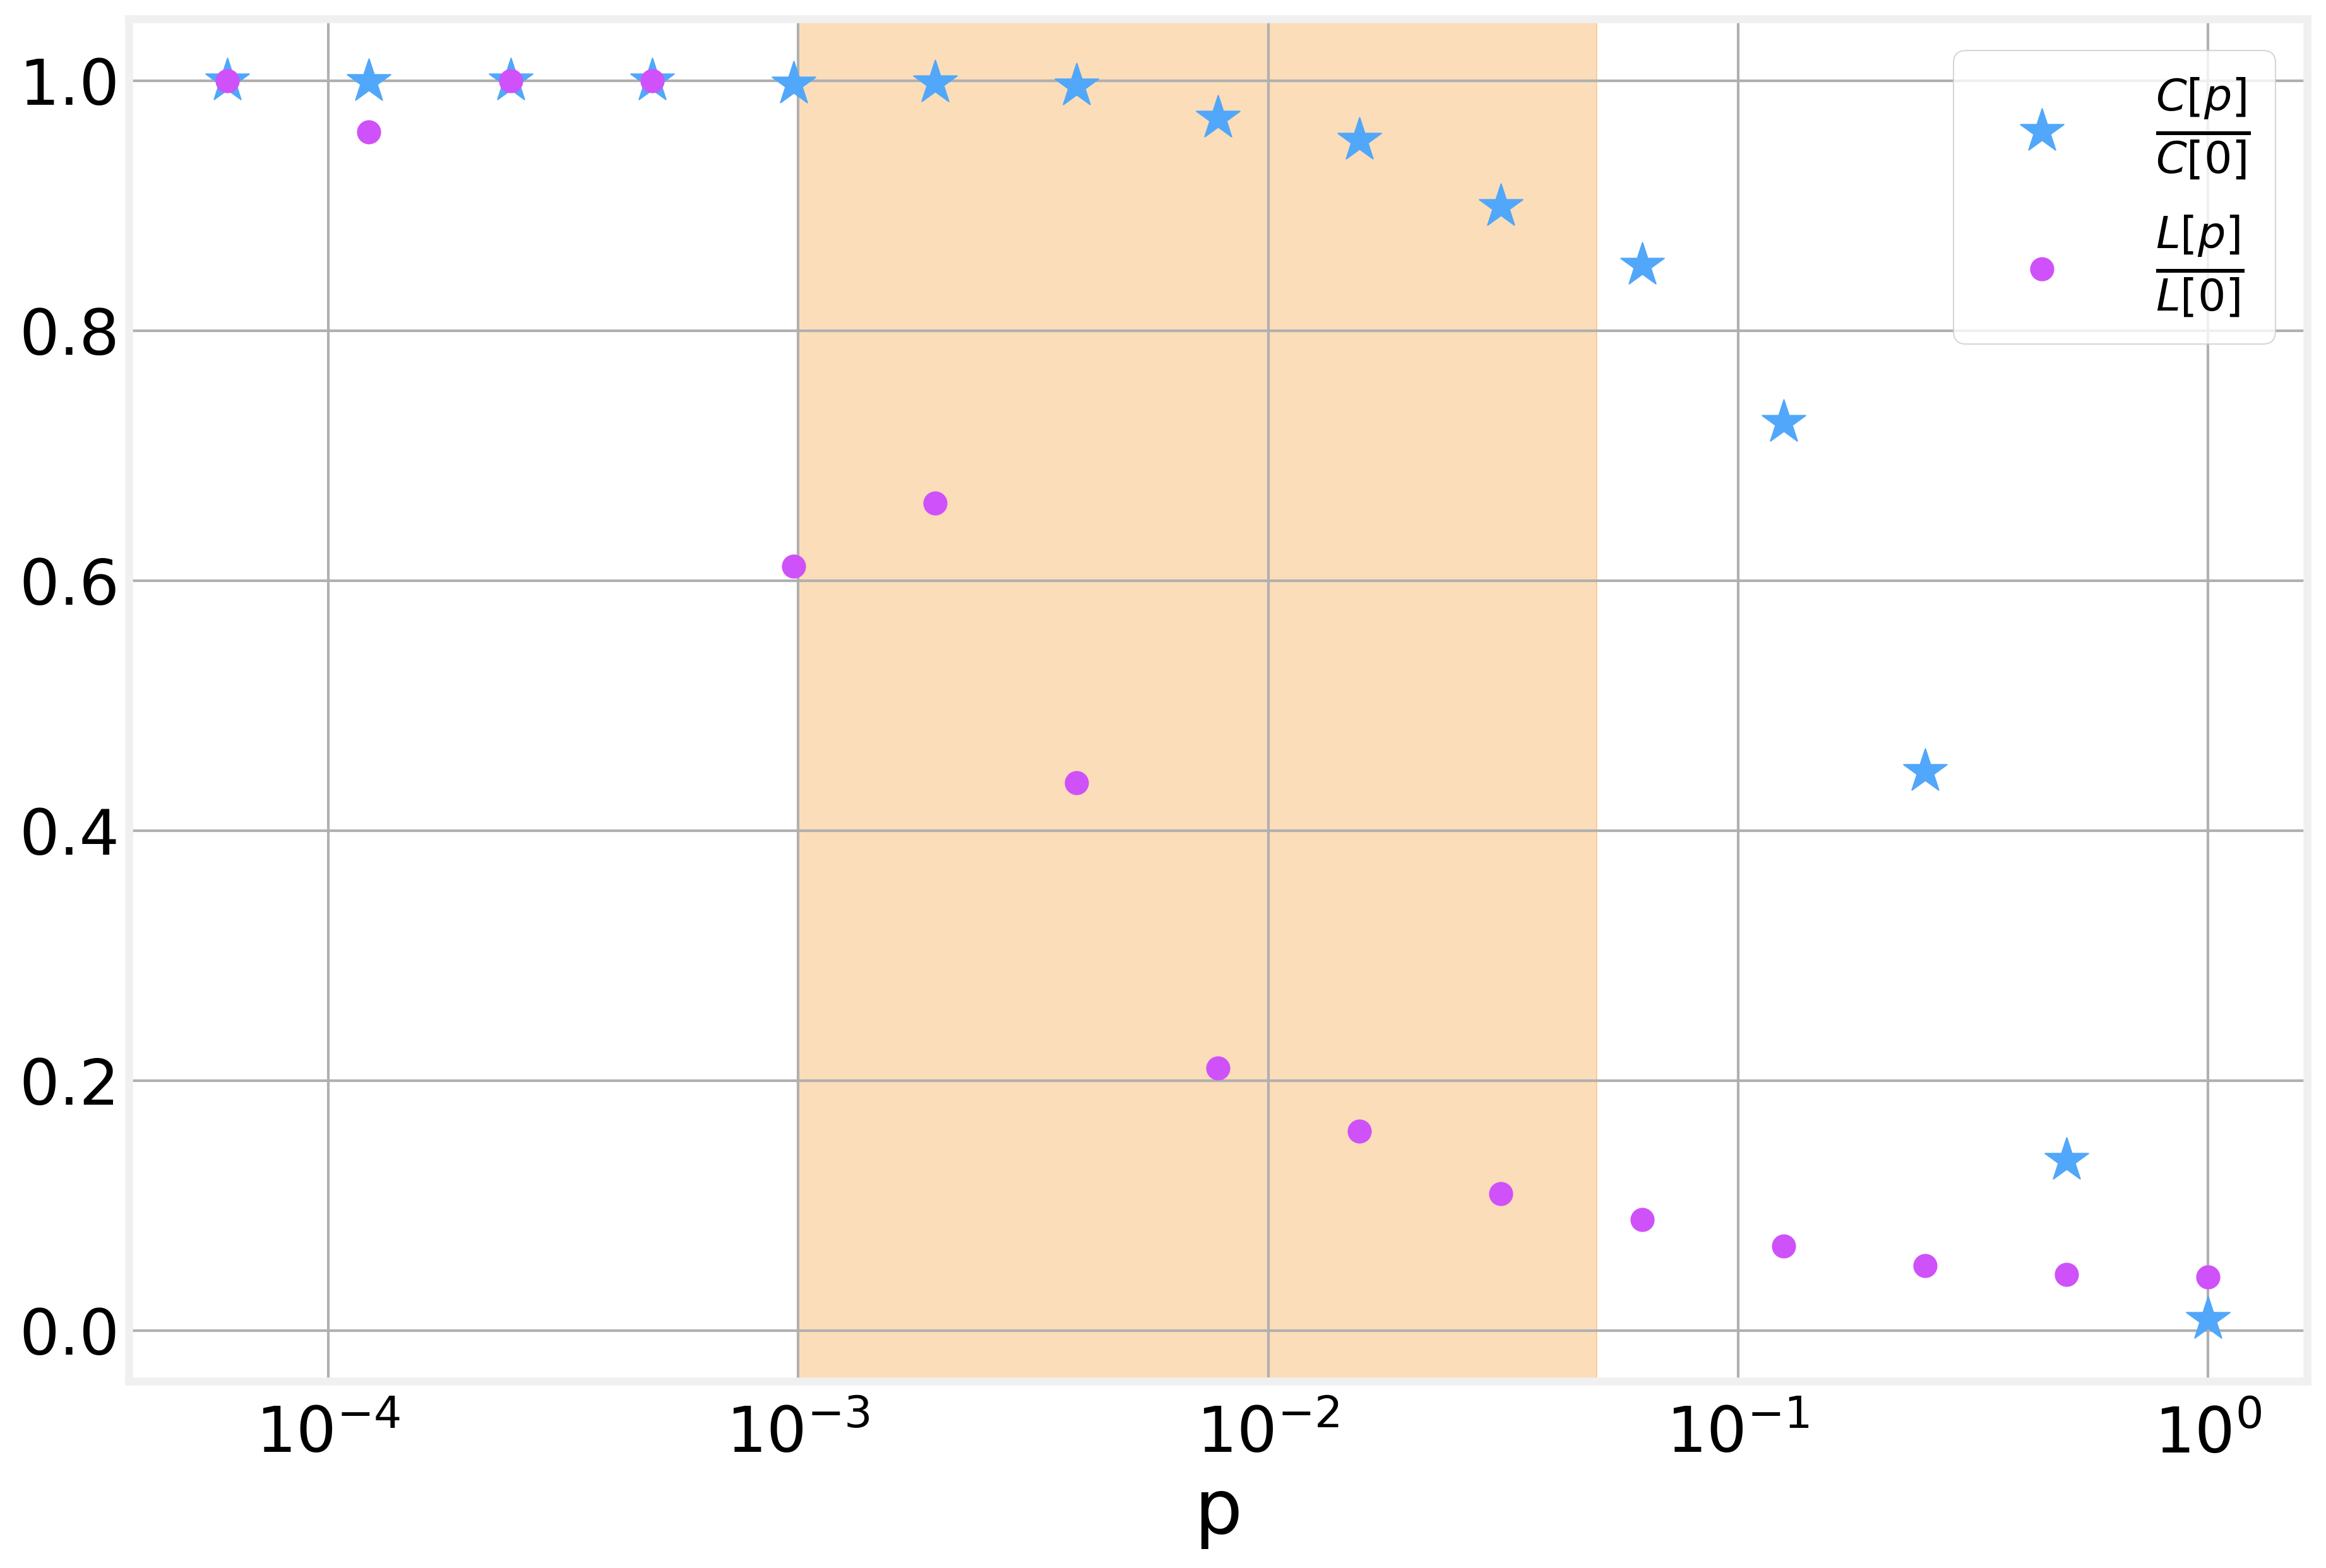

In [28]:
ax = WS_stats.plot.scatter(x='p', y='clustering', marker='*', 
                           label=r'$\frac{C[p]}{C[0]}$', 
                           color=colors[0], s=300)
WS_stats.plot.scatter(x='p', y='diameter', marker='.', 
                           label=r'$\frac{L[p]}{L[0]}$', 
                           color=colors[1], s=300, ax=ax)
ax.axvspan(xmin=0.001, xmax=0.05, color=colors[3], alpha=0.3, zorder=-3)
ax.set_xscale('log')
ax.set_ylabel(None)

for tick_label in ax.xaxis.get_majorticklabels():
    tick_label.set_y(-.01)

## Load the Higgs Reply Network

In [29]:
filename = 'data/higgs-reply_network.edgelist.gz'
url = 'https://snap.stanford.edu/data/higgs-reply_network.edgelist.gz'

if not os.path.exists(filename):
    progress_bar = None

    def tqdm_bar(current, total, width=80):
        global progress_bar

        if progress_bar is None:
            progress_bar = tqdm(total=total, unit='iB')
        
        progress_bar.update(current)
    
    print('Downloading File')
    wget.download(url, filename, bar=tqdm_bar)

reply = pd.read_csv(filename, sep=' ', 
                    header=None, names=['node_i', 'node_j', 'weight'])

Create the graph

In [30]:
G = nx.DiGraph()
G.add_edges_from(reply[['node_i', 'node_j']].values)

In [31]:
G.number_of_nodes()

38918

In [32]:
G.number_of_edges()

32523

We extract the strongly connected component

In [33]:
SCC = [comp for comp in nx.components.strongly_connected_components(G)]

We find 36132 components

In [34]:
len(SCC)

36132

We also extract the size of each SCC

In [35]:
SCC_sizes = [len(comp) for comp in SCC]

And the largest WCC has just a few hundred nodes

In [36]:
np.max(SCC_sizes)

322

In [37]:
P_size = pd.DataFrame(list(Counter(SCC_sizes).items()), columns=['size', 'N_size'])
P_size.sort_values('size', inplace=True)
P_size['N_size'] /= P_size['N_size'].sum()

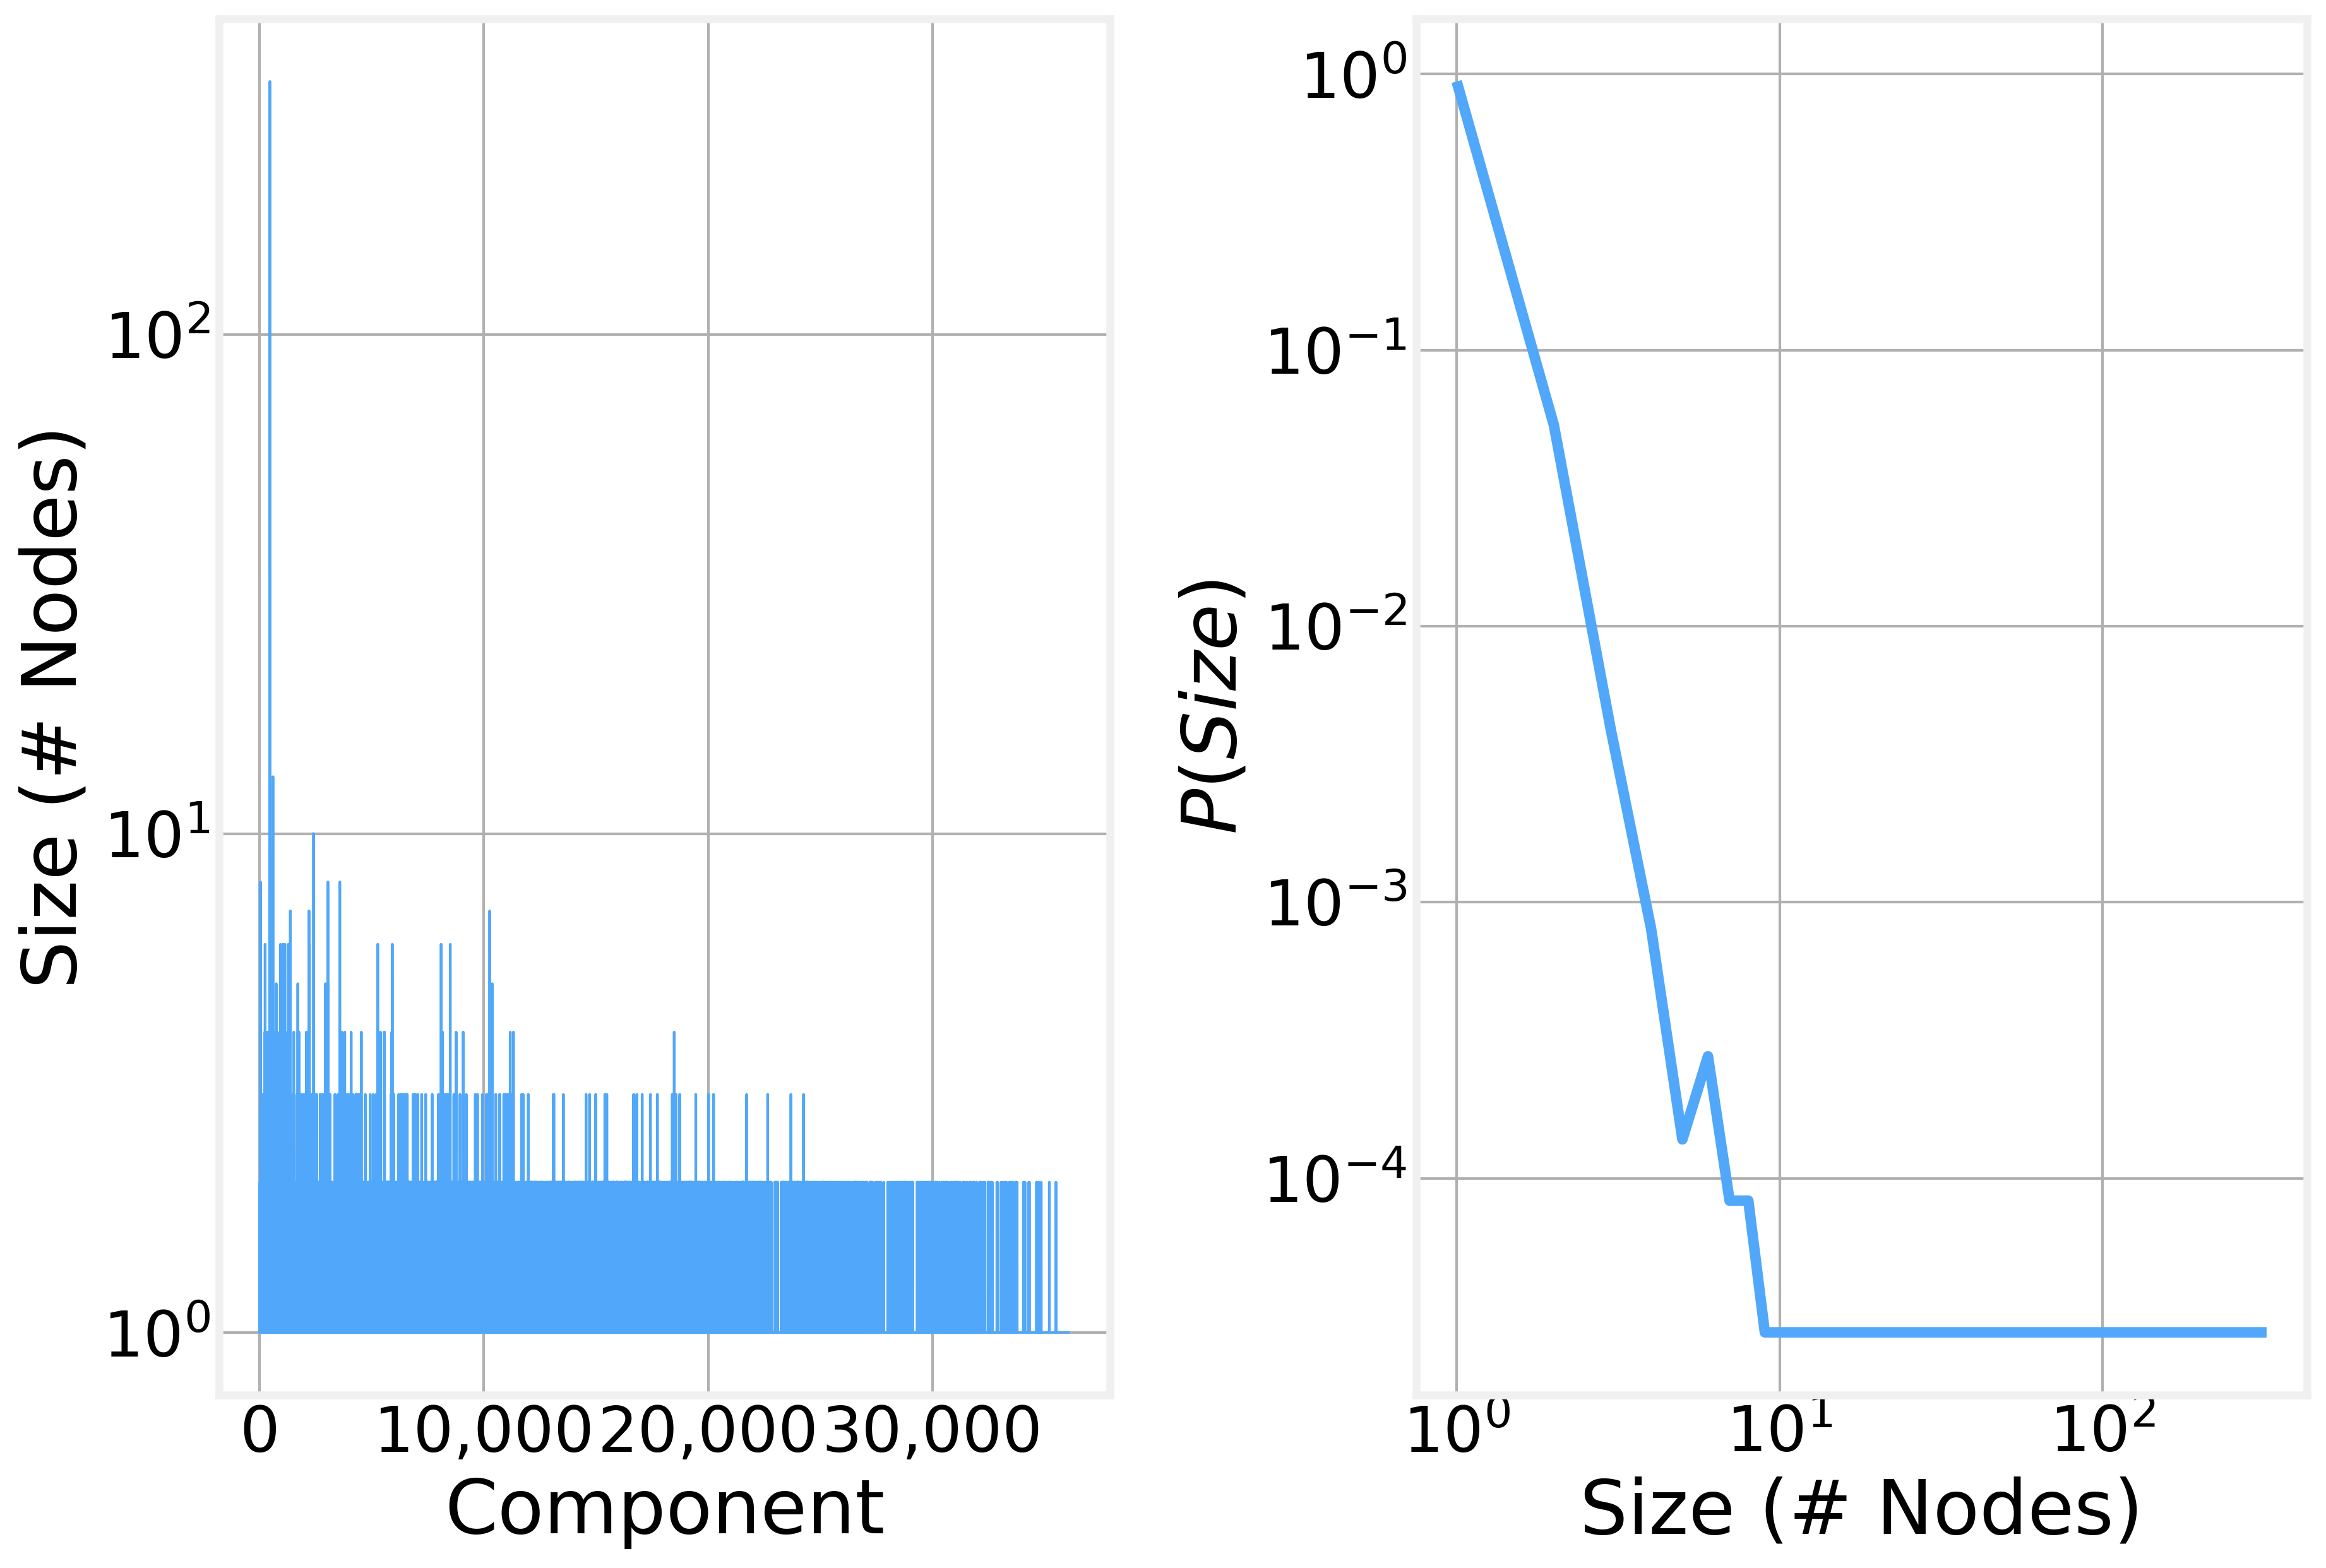

In [38]:
fig, (ax, ax2) = plt.subplots(1, 2)

ax.plot(SCC_sizes, lw=1)
ax.set_yscale('log')
ax.set_xlabel('Component')
ax.set_ylabel('Size (# Nodes)')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

P_size.plot(x='size', y='N_size', legend=False, ax=ax2)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('Size (# Nodes)')
ax2.set_ylabel(r'$P\left(Size\right)$')
fig.tight_layout()

94% of all components having just a single node.

In [39]:
P_size.iloc[P_size['N_size'].idxmax()]

size      1.000000
N_size    0.940745
Name: 0, dtype: float64

We extract the largest subgraph

In [40]:
largest_SCC = G.subgraph(SCC[np.argmax(SCC_sizes)])

Which is much smaller that the original graph

In [41]:
print('Number of nodes:', largest_SCC.number_of_nodes())
print('Number of edges:', largest_SCC.number_of_edges())

Number of nodes: 322
Number of edges: 708


In [42]:
degrees = dict(largest_SCC.degree())
max_degree = np.max(list(degrees.values()))

In [43]:
np.random.seed(42)
random.seed(42)
pos = nx.layout.kamada_kawai_layout(largest_SCC)

In [44]:
sizes = []
colors = []
for node in largest_SCC.nodes:
    degree = degrees[node]
    sizes.append( degree/ max_degree * 600)
    colors.append(plt.cm.Reds_r(degree / max_degree))

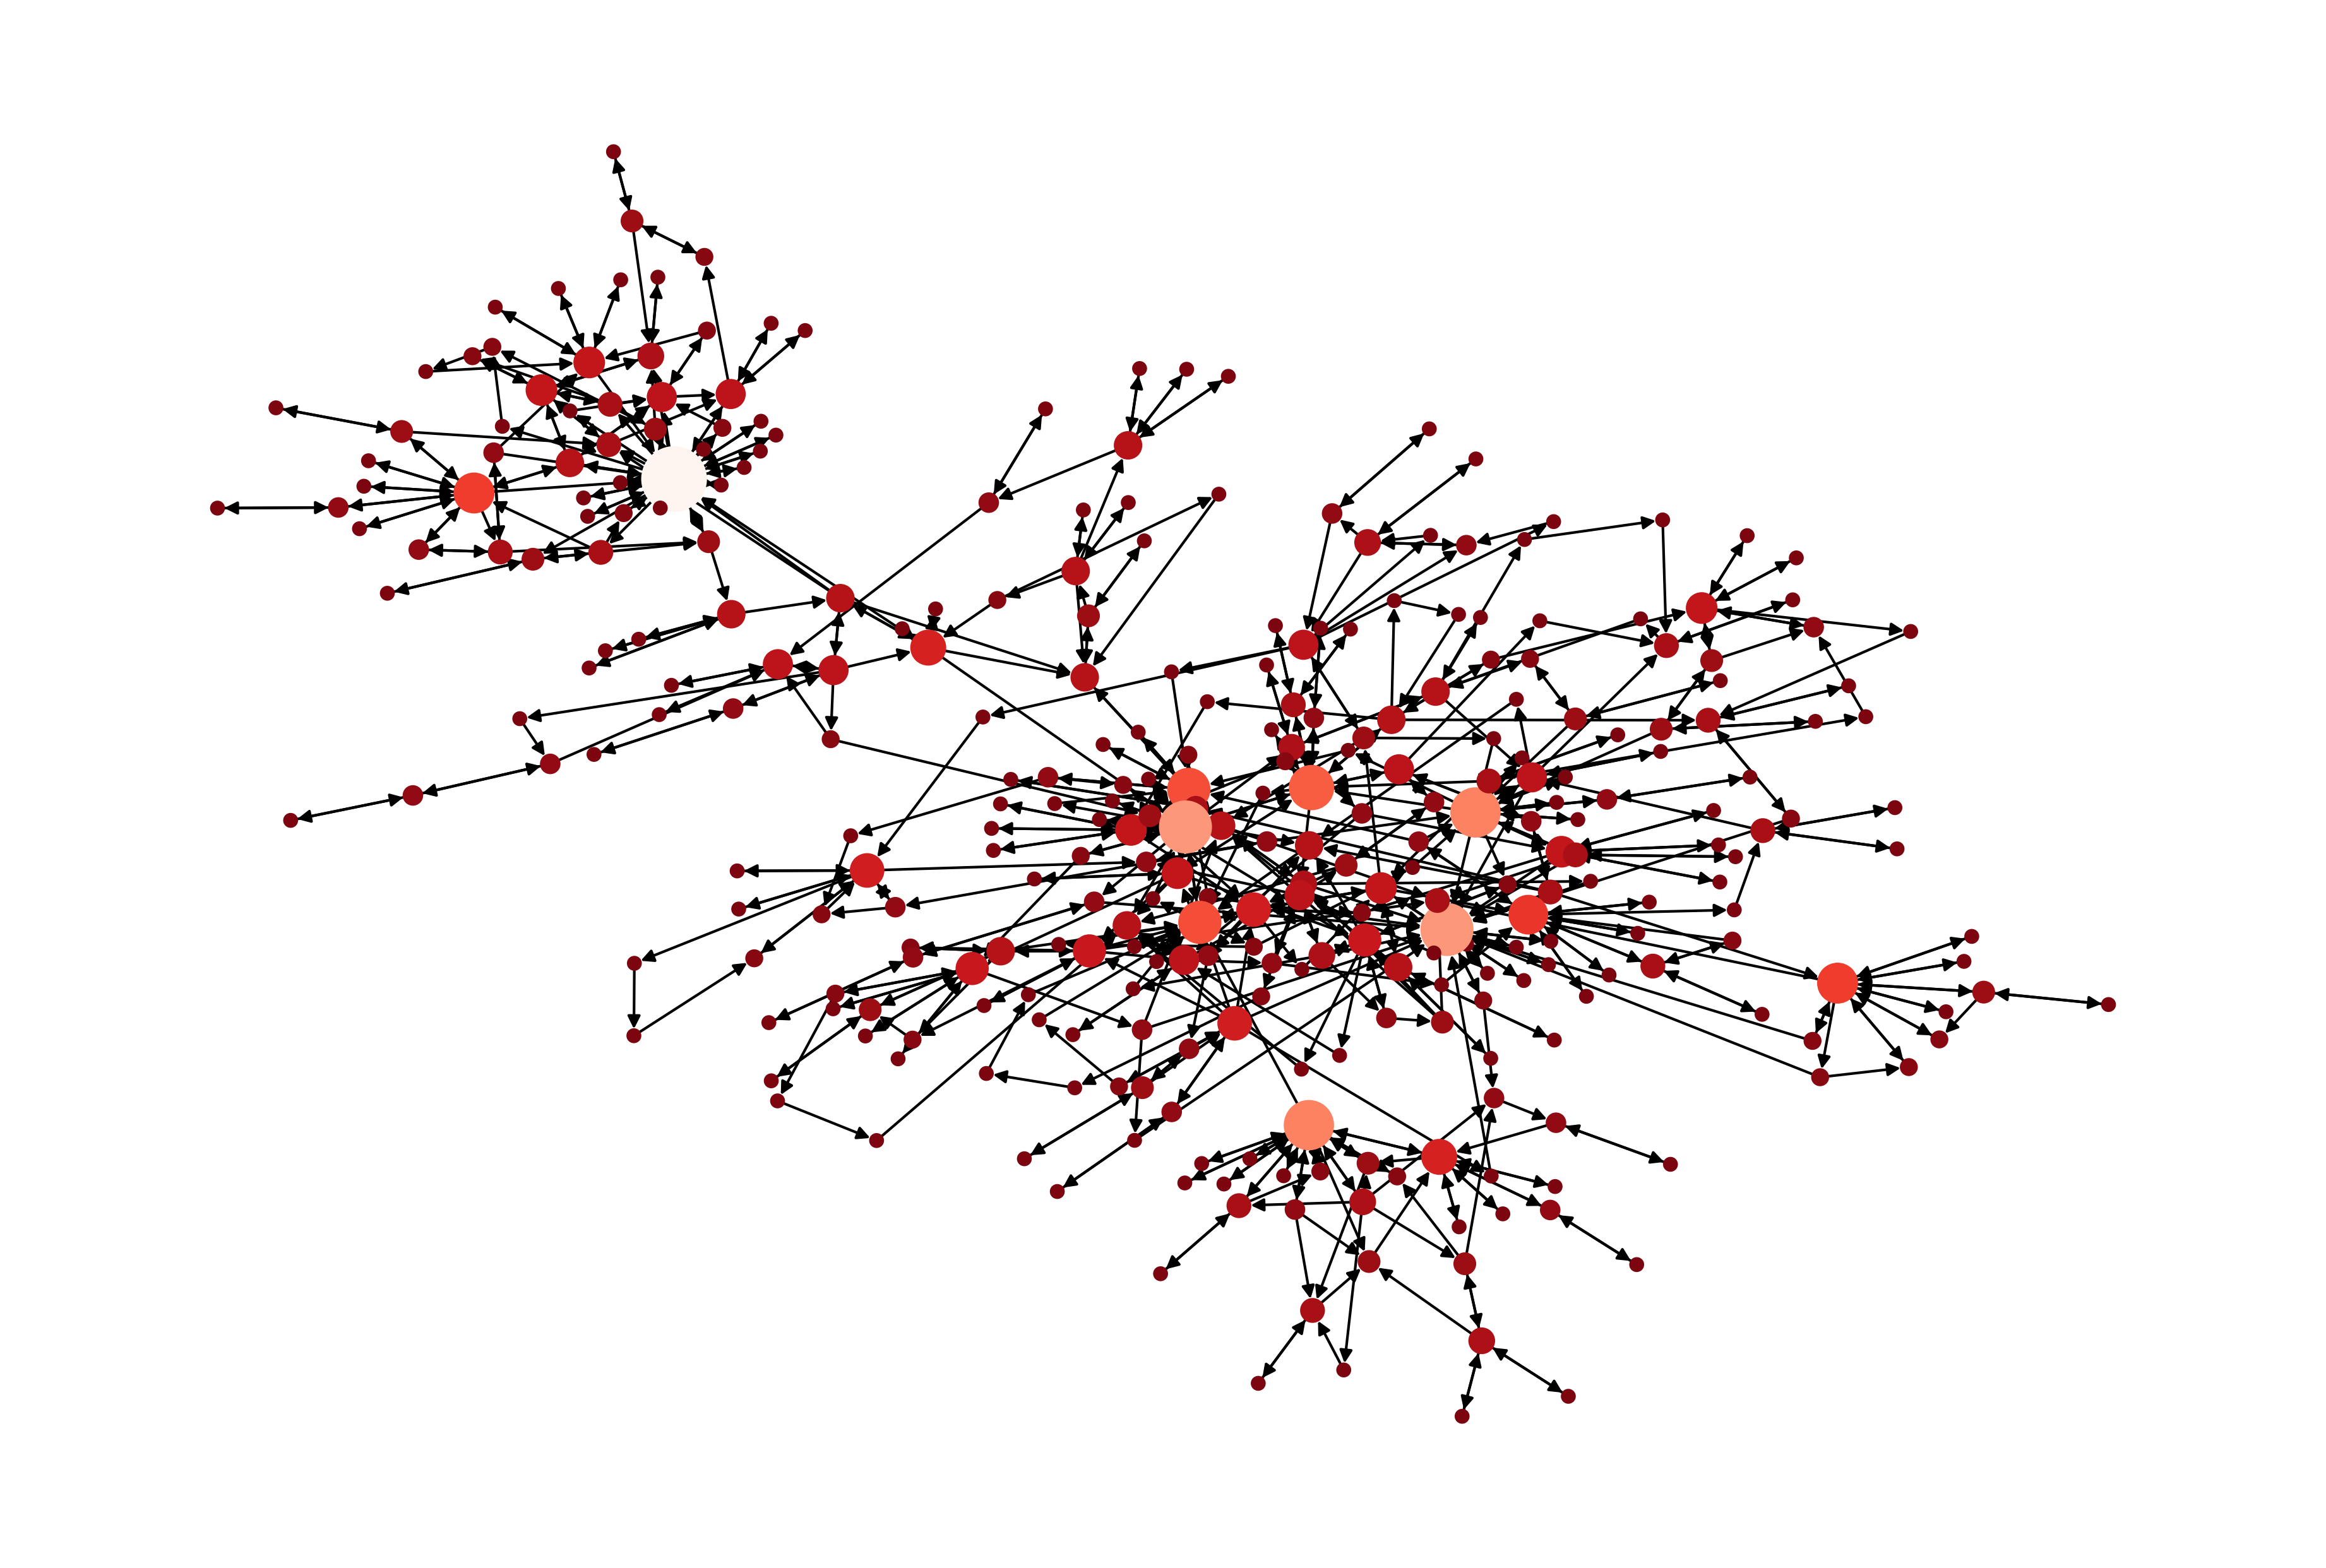

In [45]:
nx.draw_networkx_edges(largest_SCC, pos=pos, node_size=sizes)
nx.draw_networkx_nodes(largest_SCC, pos=pos, node_size=sizes, node_color=colors)
plt.gca().axis('off');

The average clustering is:

In [46]:
nx.algorithms.cluster.average_clustering(largest_SCC)

0.08037463605007264

which is pretty low. However, the diameter remains relatively large

In [47]:
nx.algorithms.distance_measures.diameter(largest_SCC.to_undirected())

12

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>